<a href="https://colab.research.google.com/github/mezlet/PPI-Inhibitors/blob/main/code/GNN_based_pipeline_Training_for_Predicting_small_molecule_inhibition_of_protein_complexes_ipynb_end_to_end.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Set the Runtime->Change Runtime Type to GPU**

# Protein 3d structure assessment with graph neural networks

In [ ]:
!fusermount -u /content/drive
!rm -rf /content/drive
%cd /content


In [ ]:
#!rm -r Data
!rm -r PPI-Inhibitors
!git clone https://github.com/adibayaseen/PPI-Inhibitors
#!pip install py3Dmol

rm: cannot remove 'PPI-Inhibitors': No such file or directory
Cloning into 'PPI-Inhibitors'...
remote: Enumerating objects: 1341, done.
remote: Total 1341 (delta 0), reused 0 (delta 0), pack-reused 1341 (from 1)
Receiving objects: 100% (1341/1341), 2.59 GiB | 44.77 MiB/s, done.
Resolving deltas: 100% (417/417), done.
Updating files: 100% (605/605), done.


In [15]:
!pip install --upgrade pip setuptools wheel
!pip install rdkit biopython==1.81 torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2 torch-geometric==2.5.3 tqdm==4.66.2 pandas==2.1.4 numpy==1.26.4 scikit-learn==1.3.2 matplotlib==3.8.3 seaborn==0.13.2 networkx==3.2.1 gdown


In [16]:
%cd PPI-Inhibitors
!mkdir -p Data

%cd Data
!wget -q https://github.com/adibayaseen/PPI-Inhibitors/raw/01ad4975fb9133825b1bf9e71b64fcdaaa5e4d8b/Data/2p2iComplexPairs.txt
!wget -q https://github.com/adibayaseen/PPI-Inhibitors/raw/01ad4975fb9133825b1bf9e71b64fcdaaa5e4d8b/Data/2p2iInhibitorsSMILES.txt
!wget -q https://github.com/adibayaseen/PPI-Inhibitors/raw/2d6bd03422602ec19147870c487e64018b52660f/Data/WriteAllexamplesRandomBindersIdsAll_24JAN_Binary.txt
!wget -q https://github.com/adibayaseen/PPI-Inhibitors/raw/b1e45884f61f792399abad2e4492f48083ab1093/Data/BindersWithComplexname.csv
%cd ..

[Errno 2] No such file or directory: 'PPI-Inhibitors'
/content/drive/MyDrive
/content/drive/MyDrive/Data
/content/drive/MyDrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
%cd '/content/drive/MyDrive'

# Make folders
!mkdir -p GNN-PPI-Inhibitor
!gdown --id 1goeDiPZSKT1Xx3j00eNG9xlqYkLLv1gW -O GNN-PPI-Inhibitor/ProteinData_dict.pickle
!gdown --id 1GOYEKLQCoGea9QQ72kujy0rdJKbUSYAE -O GNN-PPI-Inhibitor/DBD5_ProteinData_dict.pickle

/content/drive/MyDrive
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1goeDiPZSKT1Xx3j00eNG9xlqYkLLv1gW
To: /content/drive/MyDrive/GNN-PPI-Inhibitor/ProteinData_dict.pickle
100% 34.6M/34.6M [00:00<00:00, 259MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1GOYEKLQCoGea9QQ72kujy0rdJKbUSYAE
From (redirected): https://drive.google.com/uc?id=1GOYEKLQCoGea9QQ72kujy0rdJKbUSYAE&confirm=t&uuid=64489a00-6c03-465d-bf5e-b5fd137c8c2c
To: /content/drive/MyDrive/GNN-PPI-Inhibitor/DBD5_ProteinData_dict.pickle
100% 336M/336M [00:01<00:00, 297M

In [18]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Jan  9 16:43:15 2024

@author: u1876024
"""


import torch
from torch.utils.data import Dataset, DataLoader, Sampler
from torch.utils.data.sampler import WeightedRandomSampler
import numpy as np

class BalancedDataset(Dataset):
    """
    A custom dataset class that creates a balanced dataset from imbalanced data.
    This dataset calculates sample weights inversely proportional to class frequencies,
    which can be used with a WeightedRandomSampler to achieve balanced batches.

    NOTE: As it involves stochastic sampling, there is a chance that a few training examples are actually never selected.

    Attributes:
        data (array-like): The input data. Can be a list, NumPy array, or PyTorch tensor.
        labels (array-like): The labels corresponding to the data. Should be a 1D array-like object.
        sample_weights (torch.Tensor): Weights for each sample, inversely proportional to class frequencies.

    Methods:
        __len__: Returns the number of samples in the dataset.
        __getitem__(idx): Returns the sample and its corresponding label at the given index.
    """
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

        # Count the number of examples in each class
        class_counts = np.bincount(self.labels)
        # Assign weight inversely proportional to class frequency
        weights = 1. / torch.tensor(class_counts, dtype=torch.float)
        # Create a weight list for each sample
        self.sample_weights = weights[labels]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

def create_balanced_loader(data, labels, batch_size=32):
    """
    Creates a DataLoader with balanced batches for a given dataset.
    This function is useful for training models on imbalanced datasets.

    Args:
        data (array-like): The input data. Can be a list, NumPy array, or PyTorch tensor.
        labels (array-like): The labels corresponding to the data. Should be a 1D array-like object.
        batch_size (int, optional): The size of each batch. Default is 32.

    Returns:
        DataLoader: A PyTorch DataLoader that yields balanced batches.

    Usage Example:
        >>> data = [features1, features2, ...]  # Replace with your data features
        >>> labels = [label1, label2, ...]     # Replace with your data labels
        >>> balanced_loader = create_balanced_loader(data, labels, batch_size=32)
        >>> for batch_data, batch_labels in balanced_loader:
        >>>     # Train your model using the balanced batches
    """
    dataset = BalancedDataset(data, labels)
    # WeightedRandomSampler will take care of the balancing
    sampler = WeightedRandomSampler(weights=dataset.sample_weights, num_samples=len(dataset.sample_weights), replacement=True)

    loader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)
    return loader


class BinaryBalancedSampler(Sampler):
    """
    A PyTorch Sampler that returns batches with an equal number of positive and negative examples.
    The sampler oversamples from the minority class to balance the majority class, ensuring that
    each batch contains 50% positive and 50% negative examples.

    NOTE: It leads to more examples in single iteration through the data loader than in one epoch

    Attributes:
        class_vector (list or numpy array): class labels.
        batch_size (int): The size of each batch.
        n_splits (int): The number of batches/splits in the dataset.
        equivalent_epochs (float): The number of times the sampler goes over the minority class
                                   in one complete iteration of the DataLoader.

    Methods:
        gen_sample_array: Yields indices for each batch ensuring class balance.
        __iter__: Returns an iterator over batch indices.
        __len__: Returns the number of batches in the sampler.
    """
    def __init__(self, class_vector, batch_size = 10):
        """
        Arguments
        ---------
        class_vector : torch tensor
            a vector of class labels
        """
        self.batch_size = batch_size
        self.class_vector = class_vector
        YY = np.array(self.class_vector)
        U, C = np.unique(YY, return_counts=True)
        M = U[np.argmax(C)]        #find majority class
        Midx = np.nonzero(YY==M)[0] #indices of majority class
        midx = np.nonzero(YY!=M)[0] #indices of minority class
        midx_ = np.random.choice(midx,size=len(Midx))     #oversample minority indices so they are equal to majority ones
        self.YY = np.array(list(YY[Midx])+list(YY[midx_]))
        self.idx = np.array(list(Midx)+list(midx_))
        self.n_splits = int(np.ceil(len(self.idx)/self.batch_size))
        self.equivalent_epochs = len(self.idx)/len(self.class_vector)
        print('Equivalent epochs in one iteration of data loader',self.equivalent_epochs)

    def gen_sample_array(self):
        from sklearn.model_selection import StratifiedKFold
        skf = StratifiedKFold(n_splits= self.n_splits,shuffle=True)
        for tridx,ttidx in skf.split(self.idx,self.YY):
            yield np.array(self.idx[ttidx])

    def __iter__(self):
        return iter(self.gen_sample_array())

    def __len__(self):
        return self.n_splits

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

if __name__=='__main__':

    E = [(str(p_i), str(-1*c_i)) for p_i, c_i in zip(range(100), range(100))]  # Replace with your data
    Y = np.random.randint(0, 2, size=100)  # Replace with your labels
    batch_size = 10

    dataset = CustomDataset(E, Y)
    batch_sampler = BinaryBalancedSampler(Y, batch_size)
    data_loader = DataLoader(dataset, batch_sampler=batch_sampler)

    for batch in data_loader:
        print(batch)

    # Example usage of create_balanced_loader
    balanced_loader = create_balanced_loader(E, Y, batch_size)

    # Iterate over the DataLoader
    L = []
    for (pid,cid),label in balanced_loader:
        # Process your batches
        L.extend(pid)
    print(L)


Equivalent epochs in one iteration of data loader 1.04
[[('16', '21', '22', '42', '63', '98', '61', '79', '57', '58'), ('-16', '-21', '-22', '-42', '-63', '-98', '-61', '-79', '-57', '-58')], tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])]
[[('11', '23', '25', '38', '89', '92', '72', '82', '74', '82'), ('-11', '-23', '-25', '-38', '-89', '-92', '-72', '-82', '-74', '-82')], tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])]
[[('15', '36', '45', '68', '95', '60', '40', '82', '27', '94'), ('-15', '-36', '-45', '-68', '-95', '-60', '-40', '-82', '-27', '-94')], tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])]
[[('10', '59', '67', '84', '85', '55', '31', '17', '77', '49'), ('-10', '-59', '-67', '-84', '-85', '-55', '-31', '-17', '-77', '-49')], tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])]
[[('7', '12', '18', '39', '71', '80', '65', '88', '2', '72'), ('-7', '-12', '-18', '-39', '-71', '-80', '-65', '-88', '-2', '-72')], tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])]
[[('3', '43', '44', '73', '90', '37', '97', '1', '46'), ('-3', '

In [19]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
import numpy as np
import math
from itertools import product
from scipy import spatial
from os import listdir
from Bio import SeqIO
from Bio.SeqIO import FastaIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from sklearn.preprocessing import normalize
from Bio.Data import IUPACData
from Bio.PDB.Polypeptide import *
from Bio.PDB import PDBParser
import torch
import torch.optim as optim
import torch.nn as nn
import pandas as pd
import pickle
import random
from tqdm import tqdm as tqdm
# (Assuming PrepairDataset is a custom module you have)
# import PrepairDataset

def getFP(s, r=3, nBits=2048):
    compound = Chem.MolFromSmiles(s.strip())
    if compound is not None:
        fp = AllChem.GetMorganFingerprintAsBitVect(compound, r, nBits=nBits)
        #fp = pat.GetAvalonCountFP(compound,nBits=nBits)
        m = np.zeros((0,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp, m)
        return m

def twomerFromSeq(s):
    k=2
    groups={'A':'1','V':'1','G':'1','I':'2','L':'2','F':'2','P':'2','Y':'3',
            'M':'3','T':'3','S':'3','H':'4','N':'4','Q':'4','W':'4',
            'R':'5','K':'5','D':'6','E':'6','C':'7'}
    crossproduct=[''.join (i) for i in product("1234567",repeat=k)]
    for i in range (0,len(crossproduct)): crossproduct[i]=int(crossproduct[i])
    ind=[]
    for i in range (0,len(crossproduct)): ind.append(i)
    combinations=dict(zip(crossproduct,ind))
    V=np.zeros(int((math.pow(7,k))))      #defines a vector of 343 length with zero entries
    try:
        for j in range (0,len(s)-k+1):
            kmer=s[j:j+k]
            c=''
            for l in range(0,k):
                c+=groups[kmer[l]]
            V[combinations[int(c)]]+=1
    except:
        count={'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0}
        for q in range(0,len(s)):
            if s[q]=='A' or s[q]=='V' or s[q]=='G':
                count['1']+=1
            if s[q]=='I' or s[q]=='L'or s[q]=='F' or s[q]=='P':
                count['2']+=1
            if s[q]=='Y' or s[q]=='M'or s[q]=='T' or s[q]=='S':
                count['3']+=1
            if s[q]=='H' or s[q]=='N'or s[q]=='Q' or s[q]=='W':
                count['4']+=1
            if s[q]=='R' or s[q]=='K':
                count['5']+=1
            if s[q]=='D' or s[q]=='E':
                count['6']+=1
            if s[q]=='C':
                count['7']+=1
        val=list(count.values()  )           #[ 0,0,0,0,0,0,0]
        key=list(count.keys()     )           #['1', '2', '3', '4', '5', '6', '7']
        m=0
        ind=0
        for t in range(0,len(val)):     #find maximum value from val
            if m<val[t]:
                m=val[t]
                ind=t
        m=key [ind]                     # m=group number of maximum occuring group alphabets in protein
        for j in range (0,len(s)-k+1):
            kmer=s[j:j+k]
            c=''
            for l in range(0,k):
                if kmer[l] not in groups:
                    c+=m
                else:
                    c+=groups[kmer[l]]
            V[combinations[int(c)]]+=1
    V=V/(len(s)-1)
    return np.array(V)

def chainLabel(Cname_T,xl_T,Cname,xl):
    """
    Cname_T: Target chain Name
    xl_T: Target chain co-ordinates
    Cname: Off Target chain Name
    xl: Off Target chain co-ordinates
    """
    tc = getCoords(xl_T)
    nc = getCoords(xl)
    D = getDist(tc, nc, thr = 8.0)
    feats=extract_feats(generate_pair_features(D,xl_T,xl))
    return feats

def generate_pair_features(dist_info,xl,xr):
    prot_dic=make_dic()
    #    pdb.set_trace()
    for rec in dist_info:
        try:
            l_letter= three_to_one(xl[rec[0]].get_resname())
            r_letter= three_to_one(xr[rec[1]].get_resname())
            #            print(l_letter,l_letter)
            if (l_letter,r_letter) in prot_dic.keys():
                prot_dic[(l_letter,r_letter)]+=1
            elif (r_letter,l_letter) in prot_dic.keys():
                prot_dic[(r_letter,l_letter)]+=1
        except:
            prot_dic[('_','_')]+=1
    return prot_dic

def getCoords(R):
    """
    Get atom coordinates given a list of biopython residues
    """
    Coords = []
    for (idx, r) in enumerate(R):
        v = [ak.get_coord() for ak in r.get_list()]
        Coords.append(v)
    return Coords

def processProtein(UniqueProtein, PdBloc):#, PdBloc):
        data_list = []

        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda:0" if use_cuda else "cpu")
        PData_dict={}
        for i in range(len(UniqueProtein)):
            #print('Converting PDB to Graph: {}/{}'.format(i+1, len(UniqueProtein)))
            UniqueProtein[i]=UniqueProtein[i].split('.pdb')[0]
            P1=PdBloc+UniqueProtein[i]+'.pdb'
            #if P1 in UniqueProtein:
            parser = PDBParser()
            with warnings.catch_warnings(record=True) as w:
              structure = parser.get_structure("", P1)
            one_hot_atom=(atom1(structure))

            one_hot_res=(res1(structure))
            neigh_same_res,neigh_diff_res=(neigh1(structure))
            # make the graph ready for PyTorch Geometrics GCN algorithms:
            one_hot_atom=torch.tensor(one_hot_atom,dtype=torch.float32).to(device)
            one_hot_res=torch.tensor(one_hot_res,dtype=torch.float32).to(device)
            neigh_same_res=torch.tensor(neigh_same_res).to(device).long()
            neigh_diff_res=torch.tensor(neigh_diff_res).to(device).long()
            GNNData = [one_hot_atom,one_hot_res,neigh_same_res,neigh_diff_res]
            PData_dict[UniqueProtein[i]]= GNNData
        return PData_dict

def InterfaceFeatures(Complexs,pdbloc):
    Found =  listdir(pdbloc)
    InterfaceFeatures=[];InterfaceFeatures=dict(InterfaceFeatures)
    comp_id=list(set(Complexs))
    for ids in range(len(comp_id)):
        if comp_id[ids]+'.pdb' in Found:
            stx=pdbloc+'/'+comp_id[ids]+'.pdb'#'/2XA0.pdb'
            chains=Struct2chain(stx)
            for j in range(len(chains)):
                Cname_T,seq_T,L_T,xl_T=chains[j]
                for k in range(j,len(chains)):
                    Cname,seq,L,xl=chains[k]
                    #if Cname_T!=Cname and Cname!=' 'and Cname_T!=' ':
                    name=comp_id[ids]#+'_'+Cname_T+'_2_'+Cname
                    Interface=chainLabel(Cname_T,xl_T,Cname,xl)
                    InterfaceF=np.array(Interface)
                    InterfaceF=normalize(np.atleast_2d(InterfaceF), norm='l2', copy=True, axis=1, return_norm=False)
                    if name not in InterfaceFeatures.keys():
                        InterfaceFeatures[name]=Interface
    #pickle.dump(InterfaceFeatures, open(path+Filename+"_InterfaceFeatures.npy", "wb"))
    return InterfaceFeatures

def getDist(C0, C1, thr=np.inf):
    """
    """
    N0 = []
    N1 = []
    for i in range(len(C0)):
        for j in range(len(C1)):
            d = spatial.distance.cdist(C0[i], C1[j]).min()
            # dji=spatial.distance.cdist(C1[j], C0[i]).min()
            #d=min(dij,dji)
            #print d
            if (d < thr):  # and not np.isnan(self.Phi[i]) and not np.isnan(self.Phi[j])
                N0.append((i, j, d))
                N1.append((j, i, d))
    return (N0, N1)

def prot_feats_seq(seq):
    #Interfacedict=pickle.load(open(path+"InhibitorNewModel2022/InterfaceFeatures2chainsSVM.npy","rb"))
    #InterfaceF=Interfacedict[complexname]
    aa=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    f=[]
    X = ProteinAnalysis(str(seq))
    X.molecular_weight() #throws an error if 'X' in sequence. we skip such sequences
    p=X.get_amino_acids_percent()
    dp=[]
    for a in aa:
        dp.append(p[a])
    dp=np.array(dp)
    dp=normalize(np.atleast_2d(dp), norm='l2', copy=True, axis=1, return_norm=False)
    f.extend(dp[0])
    tm=np.array(twomerFromSeq(str(seq)))
    tm=normalize(np.atleast_2d(tm), norm='l2', copy=True, axis=1,return_norm=False)
    f.extend(tm[0])
    return np.array(f)

def Struct2chain(stx):
    """
    Seq: sequence of the chain
    seq_L:sequence Length
    """
    p = PDBParser()
    L=[]
    stx=p.get_structure('X',stx)
    for model in stx:
        for C in model:
            RL=[]
            for R in C:
                RL.append(R)
            pp=PPBuilder().build_peptides(C)
            if len(pp)==0:
                pp=CaPPBuilder().build_peptides(C)
            seq=''.join([str(p.get_sequence()) for p in pp])
            #seq=''.join([p.get_sequence().tostring() for p in pp])
            seq_L=len(seq)
            L.append((C.full_id[2],seq,seq_L,RL))
    return L

def extract_feats(dic):
    feats=[]
    key_list=np.load('/content/PPI-Inhibitors/Features/'+'prote_letter_pair_keys.npy')#to keep features order same
    for key in key_list:
        #        pdb.set_trace()
        feats.append(dic[(key[0].decode('utf-8'),key[1].decode('utf-8'))])
    return feats

def make_dic():
    prot_dic={}
    letters=IUPACData.protein_letters
    for i in range(len(letters)):
        for j in range(i,len(letters)):
            prot_dic[(letters[i],letters[j])]=0.0
    prot_dic[('_','_')]=0.0# for Amino acids other than 20 natural
    return prot_dic

def LoadProtein_SVM_Features(UniqueProtein,Pdbloc):
    pdbname=listdir(Pdbloc)
    InterfaceFeatures=[];InterfaceFeatures=dict(InterfaceFeatures)
    SequenceFeatures=[];SequenceFeatures=dict(SequenceFeatures)
    AllFeatures=[];AllFeatures=dict(AllFeatures)
    for  b in range(len(UniqueProtein)):
        if UniqueProtein[b]+'.pdb'in pdbname:
            stx=Pdbloc+UniqueProtein[b]+'.pdb'#directory+'/2XA0.pdb'
            chains=Struct2chain(stx)
            #########Interface Features
            for j in range(len(chains)):
                Cname_T,seq_T,L_T,xl_T=chains[j]
                for k in range(j,len(chains)):
                    Cname,seq,L,xl=chains[k]
                    #if Cname_T!=Cname and Cname!=' 'and Cname_T!=' ':
                    name=UniqueProtein[b]#+'_'+Cname_T+'_2_'+Cname
                    Interface=chainLabel(Cname_T,xl_T,Cname,xl)
                    seq_TF=prot_feats_seq(seq_T)
                    seq_NTF=prot_feats_seq(seq)
                    SeQFeatures=(seq_TF+seq_NTF)/2
                    InterfaceF=np.array(Interface)
                    InterfaceF=normalize(np.atleast_2d(InterfaceF), norm='l2', copy=True, axis=1, return_norm=False)
                    if name not in InterfaceFeatures.keys():
                        InterfaceFeatures[name]=Interface
                        SequenceFeatures[name]=SeQFeatures
                        AllFeatures[name]=np.append(SeQFeatures,Interface)
    return InterfaceFeatures,SequenceFeatures,AllFeatures

def External_GenerateRandomNegative(posexamples):
    NegtiveRatio=1
    ###SuperDrugbank###Names
    SuperdrugNames=pd.read_excel('/content/PPI-Inhibitors/Data/approved_drugs_chemical_structure_identifiers.xlsx',usecols="B").values#'approved_drugs_chemical_structure_identifiers.xlsx'
    SuperdrugNames=SuperdrugNames[1:]
    SuperdrugNames = np.array([s[0] for s in SuperdrugNames])
    ###############SuperDrugbank
    df_Superdrug=pd.read_excel('/content/PPI-Inhibitors/Data/approved_drugs_chemical_structure_identifiers.xlsx',usecols="C").values
    df_Superdrug=df_Superdrug[1:]
    ###
    df_Superdrug_Compounds=np.array([c[0] for c in df_Superdrug])#3638
    SuperDrug_dict=dict (zip (SuperdrugNames,df_Superdrug_Compounds))
    ################
    #path='/content/drive/MyDrive/GNN-PPI-Inhibitor/'
    DBD5_ProteinData_dict=pickle.load(open('/content/PPI-Inhibitors/Features/NewUbench5InterfaceandSeq_dict.npy',"rb"))
    Ubench5CompNames=list (set (list (DBD5_ProteinData_dict.keys())))
    ####
    AllNeg=[];AllPos=[];complex_ligand_dict={};
    for key,val in  posexamples:
        #print(key,val,posexamples[key,val][1])
        if key not in complex_ligand_dict:
            complex_ligand_dict[key]=posexamples[key,val][1]
        else:
            #print("else",key,val)
            complex_ligand_dict[key]=np.append( complex_ligand_dict.get(key, ()) ,posexamples[key,val][1])

    Complexnames=list (complex_ligand_dict.keys())
    totalcomp=list (set (complex_ligand_dict.keys()))

    for everycomp in totalcomp:
        origanlL=complex_ligand_dict[everycomp]
        #print(origanlL)
        #print("complexname=",everycomp,"origanlInhibitors",len(origanlL))
        pos=[(everycomp,origanlL[t]) for t in range(len(origanlL))]
        #print(pos)
        NN =NegtiveRatio*len(pos)
        negs = []
        AllPos.extend(pos)
        while (len(negs)<NN):# and len(negs)<(len(totalligands_train)-len(origanlL)):
            LigandR = random.choice(SuperdrugNames)
            LigandR_smile=SuperDrug_dict[LigandR]
            Npair=((everycomp,LigandR_smile))
            if LigandR  not in origanlL and Npair not in AllNeg and Npair not in AllPos and getFP(LigandR_smile) is not None:
                negs.append(Npair)
                #                print("Npair SuperdrugNames",Npair)
        AllNeg.extend(negs)

    #print("N=",len(AllNeg),"P",len(AllPos))
    #print("second method Cr")

    for everycomp in totalcomp:
        origanlL=complex_ligand_dict[everycomp]
        #        print("everycomp=",everycomp,"origanlL",len(origanlL))
        pos=[(everycomp,origanlL[t]) for t in range(len(origanlL))]
        NN =NegtiveRatio*len(pos)
        negs = []
        while (len(negs)<NN):
            for everyL in origanlL:
                ComplexR = random.choice(Ubench5CompNames)
                Npair=((ComplexR,everyL))
                if ComplexR!=everycomp and Npair not in AllNeg and Npair not in AllPos:
                    #                    print("ComplexR,everycomp)",Npair)
                    negs.append(Npair)
        AllNeg.extend(negs)
    ###################
    #print("N=",len(AllNeg),"P",len(AllPos))
    return np.array(AllPos),np.array(AllNeg),SuperDrug_dict

def PredictScorefromFile(filename,Pdbloc,Pscaler,Cscaler,trainedModel_IPPI,train_GNN,LOCOcomplexname):
    githubpath='/content/PPI-Inhibitors/'
    #filename,Pdbloc,Pscaler,Cscaler,trainedModel_IPPI,train_GNN=githubpath+'Data/External data/2dyh_all.txt',githubpath+'Data/External data/pdb/',Pscaler,Cscaler,IPPI_Net,GNN_model
    with open(filename) as f:
        D = f.readlines()

    InhibitedComp=[];PdbId=[];Ligandnames=[];SMILES=[];targets=[];
    All_data_list=[]

    #2XA0_A_2_B 2O21 2XA0 43B c1ccc(cc1)CCc2nc3cc(ccc3s2)c4ccc(cc4)C(=O)NS(=O)(=O)c5ccc(c(c5)[N](=O)[O-])NCCSc6ccccc6  1
    for d in tqdm(D):
        Pdbid,inhibtedc,Ligandid,smiles = d.split()
        if getFP(smiles) is not None:
            PdbId.append(Pdbid);Ligandnames.append(Ligandid);SMILES.append(smiles);InhibitedComp.append(inhibtedc);#labels.append(float (y));

    ################
    """
    Result_dict={}
    pos=dict (zip(zip(PdbId, Ligandnames),zip(InhibitedComp,SMILES)))
    Pos,Negs,SuperDrug_dict=External_GenerateRandomNegative(pos)
    poslabel=1.0*np.ones(len(Pos));neglabel=-1.0*np.ones(len(Negs));targets=np.append(poslabel,neglabel )
    All_examples=[];All_examples.extend(Pos);All_examples.extend(Negs)
    #Write File for External
    External_All_Examples=open('/content/drive/MyDrive/GNN-PPI-Inhibitor/_'+LOCOcomplexname+'_'+filename.split('.txt')[0].split('/')[-1]+'_External_All_Examples.txt',"w")
    """
    complexnames=[];SMILES=[];targets=[];
    #/content/PPI-Inhibitors/Data/External data/2dyh_all_External_All_Examples.txt
    with open('/content/PPI-Inhibitors/Data/External data/'+filename.split('.txt')[0].split('/')[-1]+'_External_All_Examples.txt') as f:
        D = f.readlines()

    for d in tqdm(D):
        complexname,smiles,target= d.split()
        complexnames.append(complexname);SMILES.append(smiles);targets.append(target);#All_examples.append()

    pdbname=listdir(Pdbloc);mypdb=[]
    for p in pdbname:
        if p.split('.pdb')[0] in Pdbid:
            mypdb.append(p)

    UniqueProtein=list (set (mypdb))
    External_Protein_GNN_Data_dict=processProtein(UniqueProtein,Pdbloc)

    ##########for Seq+interface features
    #pdbname=listdir(Pdbloc)
    s,i,External_ProteinSeqandInterfaceData_dict=LoadProtein_SVM_Features(UniqueProtein,Pdbloc)

    ##############3 for sequence fedatures of DBD5 pdb's
    Ubench5InterfaceandSeq_dict=pickle.load(open(githubpath+'Features/NewUbench5InterfaceandSeq_dict.npy',"rb"))
    All_External_ProteinSeqandInterfaceData_dict=dict( list (External_ProteinSeqandInterfaceData_dict.items())+list (Ubench5InterfaceandSeq_dict.items()))

    #Testing
    DBD5_Protein_GNN_Data_dict=pickle.load(open(path+'DBD5_ProteinData_dict.pickle',"rb"))
    #Pos_ProteinData_dict=pickle.load(open(path+'ProteinData_dict.pickle',"rb"))
    All_Protein_GNN_Data_dict=dict( list (External_Protein_GNN_Data_dict.items())+list (DBD5_Protein_GNN_Data_dict.items()))

    for d in All_Protein_GNN_Data_dict:
        data=All_Protein_GNN_Data_dict[d]
        All_Protein_GNN_Data_dict[d]=[data[0].cuda(),data[1].cuda(),data[2].cuda(),data[3].cuda()]

    #####################
    Cttname=[];Ctt=[];Pttname=[];Ptt=[];
    for (complexname,ligandsmile) in zip(complexnames,SMILES):#All_examples:
        Cttname.append(ligandsmile);Ctt.append(getFP(ligandsmile));
        Pttname.append(complexname);Ptt.append(All_External_ProteinSeqandInterfaceData_dict[complexname]);

    #standarization
    Ctt = Cscaler.transform(Ctt)
    Cttdict=dict (zip (Cttname,torch.FloatTensor( Ctt).cuda()))
    Ptt = Pscaler.transform(Ptt)
    Pttdict=dict (zip (Pttname,torch.FloatTensor( Ptt).cuda()))

    #########
    Y_t,Z,Targets=[],[],[]

    # Set models to evaluation mode for inference
    trainedModel_IPPI.eval()
    train_GNN.eval()

    # with torch.no_grad(): # Disable gradient calculations
    #     for target,(complexname,ligandsmile) in zip(targets,zip(complexnames,SMILES)):

    #         # 1. Get GNN features first by running the GNN model
    #         GNN_features = train_GNN(All_Protein_GNN_Data_dict[complexname])

    #         # 2. Pass the GNN features (not the model) to the MLP
    #         test_score = trainedModel_IPPI(GNN_features, Cttdict[ligandsmile], Pttdict[complexname])

    #         test_score=test_score.cpu().data.numpy()[0]
    #         Z.append(test_score);Targets.append(float (target))

    # return Z,Targets

    with torch.no_grad(): # Disable gradient calculations
        for target,(complexname,ligandsmile) in zip(targets,zip(complexnames,SMILES)):

            # 1. Get GNN features (already 2D: [1, 512])
            GNN_features = train_GNN(All_Protein_GNN_Data_dict[complexname])

            # 2. Get Ligand and Interface features (which are 1D)
            ligand_feats_1d = Cttdict[ligandsmile]
            interface_feats_1d = Pttdict[complexname]

            # 3. Add a batch dimension (unsqueeze) to make them 2D
            ligand_feats_2d = ligand_feats_1d.unsqueeze(0)       # Shape becomes [1, 2048]
            interface_feats_2d = interface_feats_1d.unsqueeze(0)   # Shape becomes [1, 280]

            # 4. Pass all 2D tensors to the MLP
            test_score = trainedModel_IPPI(GNN_features, ligand_feats_2d, interface_feats_2d)

            test_score=test_score.cpu().data.numpy()[0]
            Z.append(test_score);Targets.append(float (target))
    return Z, Targets

CUDA is available. Number of GPUs: 1
GPU 0: Tesla T4


100%|██████████| 15695/15695 [00:00<00:00, 804507.14it/s]


Equivalent epochs in one iteration of data loader 1.8452492066455106
test complex  3D9T


 10%|█         | 1/10 [00:14<02:10, 14.45s/it]

LOADED BEST AUCROC 0.7690925426774483 AUCPR 0.11334980968787356
AUCROC 0.7690925426774483 AUCPR 0.11334980968787356 best aucroc 0.7690925426774483



 20%|██        | 2/10 [00:29<01:58, 14.79s/it]

LOADED BEST AUCROC 0.8383872416891286 AUCPR 0.2234649256502957
AUCROC 0.8383872416891286 AUCPR 0.2234649256502957 best aucroc 0.8383872416891286



 40%|████      | 4/10 [00:57<01:25, 14.27s/it]

LOADED BEST AUCROC 0.8426549865229112 AUCPR 0.20224016953303162
AUCROC 0.8426549865229112 AUCPR 0.20224016953303162 best aucroc 0.8426549865229112



 50%|█████     | 5/10 [01:11<01:11, 14.20s/it]

LOADED BEST AUCROC 0.8495058400718779 AUCPR 0.20522655726735467
AUCROC 0.8495058400718779 AUCPR 0.20522655726735467 best aucroc 0.8495058400718779



 60%|██████    | 6/10 [01:26<00:57, 14.49s/it]

LOADED BEST AUCROC 0.8509658580413297 AUCPR 0.1943630801150489
AUCROC 0.8509658580413297 AUCPR 0.1943630801150489 best aucroc 0.8509658580413297



 70%|███████   | 7/10 [01:40<00:42, 14.32s/it]

LOADED BEST AUCROC 0.8609052111410602 AUCPR 0.2190249065701196
AUCROC 0.8609052111410602 AUCPR 0.2190249065701196 best aucroc 0.8609052111410602



100%|██████████| 1/1 [02:22<00:00, 142.08s/it]


OUTSIDE LOOP AUC of Best
Complex name 3D9T AUCROC 0.8609052111410602 AUCPR 0.2190249065701196

External validation for 3D9T...


  0%|          | 0/24 [00:00<?, ?it/s][04:52:50] DEPRECATION WARNING: please use MorganGenerator
[04:52:50] DEPRECATION WARNING: please use MorganGenerator
[04:52:50] DEPRECATION WARNING: please use MorganGenerator
[04:52:50] DEPRECATION WARNING: please use MorganGenerator
[04:52:50] DEPRECATION WARNING: please use MorganGenerator
[04:52:50] DEPRECATION WARNING: please use MorganGenerator
[04:52:50] DEPRECATION WARNING: please use MorganGenerator
[04:52:50] DEPRECATION WARNING: please use MorganGenerator
[04:52:50] DEPRECATION WARNING: please use MorganGenerator
[04:52:50] DEPRECATION WARNING: please use MorganGenerator
[04:52:50] DEPRECATION WARNING: please use MorganGenerator
[04:52:50] DEPRECATION WARNING: please use MorganGenerator
[04:52:50] DEPRECATION WARNING: please use MorganGenerator
[04:52:50] DEPRECATION WARNING: please use MorganGenerator
[04:52:50] DEPRECATION WARNING: please use MorganGenerator
[04:52:50] DEPRECATION WARNING: please use MorganGenerator
[04:52:50] DEPRECA

  Recent Pubs - AUC-ROC: 0.789, AUC-PR: 0.721


  0%|          | 0/28 [00:00<?, ?it/s][04:52:58] DEPRECATION WARNING: please use MorganGenerator
[04:52:58] DEPRECATION WARNING: please use MorganGenerator
[04:52:58] DEPRECATION WARNING: please use MorganGenerator
[04:52:58] DEPRECATION WARNING: please use MorganGenerator
[04:52:58] DEPRECATION WARNING: please use MorganGenerator
[04:52:58] DEPRECATION WARNING: please use MorganGenerator
[04:52:58] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[04:52:58] DEPRECATION WARNING: please use MorganGenerator
[04:52:58] DEPRECATION WARNING: please use MorganGenerator
[04:52:58] DEPRECATION WARNING: please use MorganGenerator
[04:52:58] DEPRECATION WARNING: please use MorganGenerator
[04:52:58] DEPRECATION WARNING: please use MorganGenerator
[04:52:58] DEPRECATION WARNING: please use MorganGenerator
[04:52:58] DEPRECATION WARNING: please use MorganGenerator
[04:52:58] DEPRECATION WARNING: please use MorganGenerator
[04:52:58] DEPRECATION WARNING: please use MorganGenerator
[04:

  COVID-19 - AUC-ROC: 0.572, AUC-PR: 0.409
Equivalent epochs in one iteration of data loader 1.8484848484848484
test complex  1BKD


  9%|▉         | 1/11 [00:12<02:00, 12.05s/it]

LOADED BEST AUCROC 0.8666666666666667 AUCPR 0.10882352941176471
AUCROC 0.8666666666666667 AUCPR 0.10882352941176471 best aucroc 0.8666666666666667



 18%|█▊        | 2/11 [00:24<01:49, 12.16s/it]

LOADED BEST AUCROC 0.8722222222222222 AUCPR 0.1125
AUCROC 0.8722222222222222 AUCPR 0.1125 best aucroc 0.8722222222222222



 27%|██▋       | 3/11 [00:36<01:37, 12.18s/it]

LOADED BEST AUCROC 0.8833333333333333 AUCPR 0.125
AUCROC 0.8833333333333333 AUCPR 0.125 best aucroc 0.8833333333333333



 36%|███▋      | 4/11 [00:48<01:24, 12.07s/it]

LOADED BEST AUCROC 0.9 AUCPR 0.1625
AUCROC 0.9 AUCPR 0.1625 best aucroc 0.9



 45%|████▌     | 5/11 [01:00<01:12, 12.01s/it]

LOADED BEST AUCROC 0.9111111111111111 AUCPR 0.17142857142857143
AUCROC 0.9111111111111111 AUCPR 0.17142857142857143 best aucroc 0.9111111111111111



 55%|█████▍    | 6/11 [01:11<00:58, 11.67s/it]

LOADED BEST AUCROC 0.9222222222222222 AUCPR 0.18333333333333335
AUCROC 0.9222222222222222 AUCPR 0.18333333333333335 best aucroc 0.9222222222222222



100%|██████████| 1/1 [02:11<00:00, 131.07s/it]


OUTSIDE LOOP AUC of Best
Complex name 1BKD AUCROC 0.9222222222222222 AUCPR 0.18333333333333335

External validation for 1BKD...


  0%|          | 0/24 [00:00<?, ?it/s][04:55:29] DEPRECATION WARNING: please use MorganGenerator
[04:55:29] DEPRECATION WARNING: please use MorganGenerator
[04:55:29] DEPRECATION WARNING: please use MorganGenerator
[04:55:29] DEPRECATION WARNING: please use MorganGenerator
[04:55:29] DEPRECATION WARNING: please use MorganGenerator
[04:55:29] DEPRECATION WARNING: please use MorganGenerator
[04:55:29] DEPRECATION WARNING: please use MorganGenerator
[04:55:29] DEPRECATION WARNING: please use MorganGenerator
[04:55:29] DEPRECATION WARNING: please use MorganGenerator
[04:55:29] DEPRECATION WARNING: please use MorganGenerator
[04:55:29] DEPRECATION WARNING: please use MorganGenerator
[04:55:29] DEPRECATION WARNING: please use MorganGenerator
[04:55:29] DEPRECATION WARNING: please use MorganGenerator
[04:55:29] DEPRECATION WARNING: please use MorganGenerator
[04:55:29] DEPRECATION WARNING: please use MorganGenerator
[04:55:29] DEPRECATION WARNING: please use MorganGenerator
[04:55:29] DEPRECA

  Recent Pubs - AUC-ROC: 0.813, AUC-PR: 0.730


  0%|          | 0/28 [00:00<?, ?it/s][04:55:36] DEPRECATION WARNING: please use MorganGenerator
[04:55:36] DEPRECATION WARNING: please use MorganGenerator
[04:55:36] DEPRECATION WARNING: please use MorganGenerator
[04:55:36] DEPRECATION WARNING: please use MorganGenerator
[04:55:36] DEPRECATION WARNING: please use MorganGenerator
[04:55:36] DEPRECATION WARNING: please use MorganGenerator
[04:55:36] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[04:55:36] DEPRECATION WARNING: please use MorganGenerator
[04:55:36] DEPRECATION WARNING: please use MorganGenerator
[04:55:36] DEPRECATION WARNING: please use MorganGenerator
[04:55:36] DEPRECATION WARNING: please use MorganGenerator
[04:55:36] DEPRECATION WARNING: please use MorganGenerator
[04:55:36] DEPRECATION WARNING: please use MorganGenerator
[04:55:36] DEPRECATION WARNING: please use MorganGenerator
[04:55:36] DEPRECATION WARNING: please use MorganGenerator
[04:55:36] DEPRECATION WARNING: please use MorganGenerator
[04:

  COVID-19 - AUC-ROC: 0.741, AUC-PR: 0.537


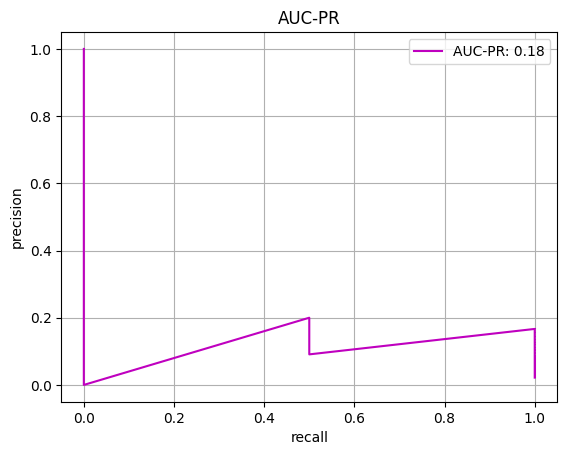

AucROC and aucpr Over all complexes 
 0.92 
 0.18 
total P:N ration 1: 0


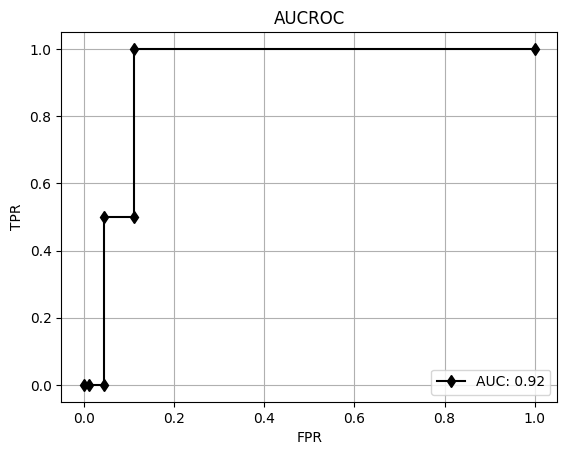

Final average over all folds,Leave one complex out nan ± nan nan ± nan


/usr/local/lib/python3.12/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.12/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.12/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.12/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.12/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [31]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Jan  9 13:06:21 2024

@author: u1876024
"""

import warnings
from Bio.PDB import *
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import glob
import torch.optim as optim
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pdb
import warnings
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import glob
from Bio.PDB import *
import warnings
from Bio.PDB import *
import numpy as np
from Bio.PDB.NeighborSearch import NeighborSearch
from tqdm import tqdm as tqdm
import pickle
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
import pandas as pd
import random
from sklearn.metrics import auc,precision_recall_curve
from torch.utils.data import Dataset
from sklearn.metrics import roc_auc_score,roc_curve,precision_score,recall_score,average_precision_score
import pickle
from rdkit import Chem
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
USE_CUDA = torch.cuda.is_available()
from torch.autograd import Variable
def cuda(v):
    if USE_CUDA:
        return v.cuda()
    return v
def toTensor(v,dtype = torch.float,requires_grad = False):
    return cuda(Variable(torch.tensor(v)).type(dtype).requires_grad_(requires_grad))
def toNumpy(v):
    if USE_CUDA:
        return v.detach().cpu().numpy()
    return v.detach().numpy()

'''
Using Sklearn One hot encoder to encode the atoms
Output is of size N*M where N is the total number of atoms and M is the total number of encoded features
'''
def atom1(structure):
    atomslist=np.array(sorted(np.array(['C', 'CA', 'CB', 'CG', 'CH2', 'N','NH2',  'OG','OH', 'O1', 'O2', 'SE','1']))).reshape(-1,1)
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(atomslist)
    atom_list=[]
    for atom in structure.get_atoms():
        if atom.get_name() in atomslist:
            atom_list.append(atom.get_name())
        else:
            atom_list.append("1")
    atoms_onehot=enc.transform(np.array(atom_list).reshape(-1,1)).toarray()
    return atoms_onehot
##############
'''
One hot encoded residue infomration using SKlearn Library

Output is N*M where N is the total number of atoms and M is the encoded features of the residues.
Any unknown  residue is mapped to 1
'''


def res1(structure):
    residuelist=np.array(sorted(np.array(['ALA', 'ARG', 'ASN', 'ASP', 'GLN', 'GLU', 'GLY', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL', 'CYS', 'HIS','1']))).reshape(-1,1)
    encr = OneHotEncoder(handle_unknown='ignore')
    encr.fit(residuelist)
    residue_list=[]
    for atom in structure.get_atoms():
        if atom.get_parent().get_resname() in residuelist:
            residue_list.append((atom.get_parent()).get_resname())
        else:
            residue_list.append("1")

    res_onehot=encr.transform(np.array(residue_list).reshape(-1,1)).toarray()

    return res_onehot
###########

'''
It calculates the neighbours of each atom i.e. 10 distinct neighbours
Output is  in the form of a ditionary representing an  adjacency list where each source atom and neighbouring atom is represented bby its sequence index .
'''


def neigh1(structure):
    #atom_list is a numpy array  that   contains all the atoms of the pdb file in atom object
    atom_list=np.array([atom for atom in structure.get_atoms()])

    #for atom in structure.get_atoms():
    #    atom_list.append(atom)
    #neighbour_list contains all the  neighbour atomic pairs  i.e. like if N has neighbours O and C then it is stored as [[N,C],[N,O]] i.e. has dimension N*2 where N is the total number of possible neighbours all the atoms have in an unsorted manner and it stores in the form of  atom object


    p4=NeighborSearch(atom_list)
    neighbour_list=p4.search_all(6,level="A")
    neighbour_list=np.array(neighbour_list)

    #dist is the distance between the neighbour and the source atom  i.e. dimension is N*1
    dist=np.array(neighbour_list[:,0]-neighbour_list[:,1])
    #sorting in ascending order
    place=np.argsort(dist)
    sorted_neighbour_list=neighbour_list[place]

    #old_atom_number is used for  storing atom id of the original protein before sorting
    #old_residue_number is used for storing residue number of the original protein before sorting
    source_vertex_list_atom_object=np.array(sorted_neighbour_list[:,0])
    len_source_vertex=len(source_vertex_list_atom_object)
    neighbour_vertex_with_respect_each_source_atom_object=np.array(sorted_neighbour_list[:,1])
    old_atom_number=[]
    old_residue_number=[]
    for i in atom_list:
        old_atom_number.append(i.get_serial_number())
        old_residue_number.append(i.get_parent().get_id()[1])
    old_atom_number=np.array(old_atom_number)
    old_residue_number=np.array(old_residue_number)
    req_no=len(neighbour_list)
    total_atoms=len(atom_list)
    #neigh_same_res is the 2D numpy array to store the indices of the  neighbours of  same residue and is of the shape N*10 where N is the total number of atoms
    #neigh_diff_res is 2D numpy array to store  the indices of the  neighbours of different residue
    #same_flag is used to restrict the neighbours belonging to same residue  to 10
    #diff_flag is used to restrict the neighbours belonging to different residue to 10
    neigh_same_res=np.array([[-1]*10 for i in range(total_atoms)])
    neigh_diff_res=np.array([[-1]*10 for i in range(total_atoms)])
    same_flag=[0]*total_atoms
    diff_flag=[0]*total_atoms
    for i in range(len_source_vertex):
        source_atom_id=source_vertex_list_atom_object[i].get_serial_number()
        neigh_atom_id=neighbour_vertex_with_respect_each_source_atom_object[i].get_serial_number()
        source_atom_res=source_vertex_list_atom_object[i].get_parent().get_id()[1]
        neigh_atom_res=neighbour_vertex_with_respect_each_source_atom_object[i].get_parent().get_id()[1]
        #finding out index of the source and neighbouring atoms from the original atom array with respect to their residue id and atom id
        temp_index1=np.where(source_atom_id==old_atom_number)[0]

        temp_index2=np.where(neigh_atom_id==old_atom_number)[0]
        for i1 in temp_index1:
            if old_residue_number[i1]==source_atom_res:
                source_index=i1
                break
        for i1 in temp_index2:
            if old_residue_number[i1]==neigh_atom_res:
                neigh_index=i1
                break
        #if both the residues are same

        if source_atom_res==neigh_atom_res :

            #limiting the number of neighbours of same residue to 10

            if int(same_flag[source_index])< 10:
                neigh_same_res[source_index][same_flag[source_index]]=neigh_index
                same_flag[source_index]+=1

            if int(same_flag[neigh_index])< 10:
                neigh_same_res[neigh_index][same_flag[neigh_index]]=source_index
                same_flag[neigh_index]+=1

        # if both the residues are different
        elif source_atom_res!=neigh_atom_res :

            #limiting the number of neighbours of different residues to 10

            if int(diff_flag[source_index])< 10:
                neigh_diff_res[source_index][diff_flag[source_index]]=neigh_index
                diff_flag[source_index]+=1


            if int(diff_flag[neigh_index])< 10:

                neigh_diff_res[neigh_index][diff_flag[neigh_index]]=source_index
                diff_flag[neigh_index]+=1




    return neigh_same_res,neigh_diff_res


if torch.cuda.is_available():
    print(f"CUDA is available. Number of GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available.")
class GNN_Layer(nn.Module):

    def __init__(self, filters, v_feats, trainable=True, **kwargs):
        #pdb.set_trace()
        super(GNN_Layer, self).__init__()
        self.v_feats = v_feats
        self.filters = filters

        self.trainable = trainable
        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda:0" if use_cuda else "cpu")
        self.cuda_device=device
        self.Wsv = nn.Parameter( torch.randn(self.v_feats, self.filters, device=self.cuda_device,requires_grad=True))
        self.Wdr = nn.Parameter( torch.randn(self.v_feats, self.filters, device=self.cuda_device,requires_grad=True))
        self.Wsr = nn.Parameter( torch.randn(self.v_feats, self.filters, device=self.cuda_device,requires_grad=True))
        self.neighbours=10
        #print("Wsv shape",self.Wsv.shape)

    def forward(self, x):
        #pdb.set_trace()
        Z,same_neigh,diff_neigh = x
        node_signals = Z@self.Wsv
        neigh_signals_same=Z@self.Wsr
        neigh_signals_diff=Z@self.Wdr
        unsqueezed_same_neigh_indicator=(same_neigh>-1).unsqueeze(2)
        unsqueezed_diff_neigh_indicator=(diff_neigh>-1).unsqueeze(2)
        same_neigh_features=neigh_signals_same[same_neigh]*unsqueezed_same_neigh_indicator
        diff_neigh_features=neigh_signals_diff[diff_neigh]*unsqueezed_diff_neigh_indicator
        same_norm = torch.sum(same_neigh > -1, 1).unsqueeze(1).type(torch.float)
        diff_norm = torch.sum(diff_neigh > -1, 1).unsqueeze(1).type(torch.float)

        # To prevent divide by zero error
        same_norm[same_norm==0]=1
        diff_norm[diff_norm==0]=1
        neigh_same_atoms_signal = (torch.sum(same_neigh_features, axis=1))/same_norm
        neigh_diff_atoms_signal = (torch.sum(diff_neigh_features, axis=1))/diff_norm
        final_res = torch.relu(node_signals +neigh_same_atoms_signal+neigh_diff_atoms_signal)

        return final_res,same_neigh,diff_neigh

class GNN_First_Layer(nn.Module):

    def __init__(self, filters, trainable=True, **kwargs):

        super(GNN_First_Layer, self).__init__()
        self.filters = filters
        #pdb.set_trace()
        self.trainable = trainable
        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda:0" if use_cuda else "cpu")
        self.cuda_device = device
        self.Wv = nn.Parameter( torch.randn(13, self.filters, device=self.cuda_device,requires_grad=True))
        self.Wr = nn.Parameter( torch.randn(21,self.filters, device=self.cuda_device,requires_grad=True))
        self.Wsr= nn.Parameter( torch.randn(13, self.filters, device=self.cuda_device,requires_grad=True))
        self.Wdr= nn.Parameter( torch.randn(13, self.filters, device=self.cuda_device,requires_grad=True))
        self.neighbours=10


    def forward(self, x):
        atoms, residues,same_neigh,diff_neigh = x
        node_signals = atoms@self.Wv
        residue_signals = residues@self.Wr
        neigh_signals_same=atoms@self.Wsr
        neigh_signals_diff=atoms@self.Wdr
        unsqueezed_same_neigh_indicator=(same_neigh>-1).unsqueeze(2)
        unsqueezed_diff_neigh_indicator=(diff_neigh>-1).unsqueeze(2)
        """
        unsqueezed_same_neigh_indicator=(same_neigh>-1).unsqueeze(1)
        unsqueezed_diff_neigh_indicator=(diff_neigh>-1).unsqueeze(1)
        """
        same_neigh_features=neigh_signals_same[same_neigh]*unsqueezed_same_neigh_indicator
        diff_neigh_features=neigh_signals_diff[diff_neigh]*unsqueezed_diff_neigh_indicator
        #print("same norm",same_neigh > -1, 1)
        same_norm = torch.sum(same_neigh > -1, 1).unsqueeze(1).type(torch.float)
        diff_norm = torch.sum(diff_neigh > -1, 1).unsqueeze(1).type(torch.float)
        same_norm = torch.sum(same_neigh > -1).type(torch.float)
        diff_norm = torch.sum(diff_neigh > -1).type(torch.float)
        # To prevent divide by zero error
        same_norm[same_norm==0]=1
        diff_norm[diff_norm==0]=1
        neigh_same_atoms_signal=(torch.sum(same_neigh_features, axis=1))/same_norm
        neigh_diff_atoms_signal=(torch.sum(diff_neigh_features, axis=1))/diff_norm

        final_res = torch.relu(node_signals+residue_signals +neigh_same_atoms_signal+neigh_diff_atoms_signal)

        return final_res, same_neigh,diff_neigh


class Dense(nn.Module):
    def __init__(self, in_dims, out_dims, trainable=True, **kwargs):
        #pdb.set_trace()
        super(Dense, self).__init__()
        self.in_dims = in_dims
        self.out_dims = out_dims
        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda:0" if use_cuda else "cpu")
        self.cuda_device = device

        self.W = nn.Parameter( torch.randn(self.in_dims, self.out_dims, device=self.cuda_device,requires_grad=True))

    def forward(self, x):
        #pdb.set_trace()
        Z = torch.sigmoid(torch.matmul(x, self.W))

        return Z

class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GNN_First_Layer(filters=512)
        self.conv2 = GNN_Layer(v_feats=512, filters=1024)
        self.conv3 = GNN_Layer(v_feats=1024, filters=512)
        self.dense = Dense(in_dims=512, out_dims=1)
    def forward(self, x):
        x1=self.conv1(x)
        x2=self.conv2(x1)
        x3=self.conv3(x2)
        x=x3[0]
        x=torch.sum(x,axis=0).view(1,-1)
        x = F.normalize(x)
        return x

def readFile(filename):
  with open(filename) as f:
    D = f.readlines()
  Name=[];PdbId=[];Ligandnames=[];SMILES=[];labels=[];
  All_data_list=[]
  from tqdm import tqdm as tqdm
  #2XA0_A_2_B 2O21 2XA0 43B c1ccc(cc1)CCc2nc3cc(ccc3s2)c4ccc(cc4)C(=O)NS(=O)(=O)c5ccc(c(c5)[N](=O)[O-])NCCSc6ccccc6  1
  for d in tqdm(D):
      #if len(d)==6:
      name,inhibtedc,Pdbid,Ligandid,smiles,y = d.split()
      Name.append(name);PdbId.append(Pdbid);Ligandnames.append(Ligandid);SMILES.append(smiles);labels.append(float (y));
  return  PdbId,Ligandnames,SMILES,labels
class IPPI_MLP_Net(nn.Module):
    def __init__(self):
        super(IPPI_MLP_Net, self).__init__()
        self.fc1 = nn.Linear(2840, 1024)#4096)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 100)
        self.fc6 = nn.Linear(100, 1)
    def forward(self, PFeatures,LigandFeatures,ProteinInterfaceF):
          Cfeatures=LigandFeatures
          P_all_Features=torch.hstack((PFeatures,ProteinInterfaceF))
          PC_Features=torch.hstack((P_all_Features,Cfeatures))
          x = torch.tanh(self.fc1(PC_Features))
          x = torch.tanh(self.fc2(x))
          x = torch.relu(self.fc3(x))
          x = self.fc6(x)
          return x

#path,githubpath='/content/drive/MyDrive/GNN-PPI-Inhibitor/','/content/PPI-Inhibitors/'
path,githubpath='/content/drive/MyDrive/GNN-PPI-Inhibitor/','/content/PPI-Inhibitors/'
"""
path = location of pkl files from these links:
https://drive.google.com/file/d/1goeDiPZSKT1Xx3j00eNG9xlqYkLLv1gW/view
https://drive.google.com/file/d/1GOYEKLQCoGea9QQ72kujy0rdJKbUSYAE/view

githubpath =  location of the directory containing the github repo PPI-Inhibitors
obtained using
git clone https://github.com/adibayaseen/PPI-Inhibitors
"""
Ubench5InterfaceandSeq_dict=pickle.load(open(githubpath+'Features/NewUbench5InterfaceandSeq_dict.npy',"rb"))
Pos_seqandInterfaceF_dict=pickle.load(open(githubpath+'Features/Pos_seqandInterfaceF_dict.npy',"rb"))
Complex_AllFeatures_dict=dict( list (Pos_seqandInterfaceF_dict.items())+list (Ubench5InterfaceandSeq_dict.items()))
##############
ComplexInterfaceFeatures={}
for key in Complex_AllFeatures_dict:
  if len(key.split('_'))>1:
    compname=key.split('_')[0]
    ComplexInterfaceFeatures[compname]=Complex_AllFeatures_dict[key]#.cuda()
  else:
    ComplexInterfaceFeatures[key]=Complex_AllFeatures_dict[key]#.cuda()
CompoundFingerprintFeaturesDict=pickle.load(open(githubpath+'Features/Compound_Fingerprint_Features_Dict.npy',"rb"))
#Load Protein data for GNN
path='/content/drive/MyDrive/GNN-PPI-Inhibitor/'
ProteinDataGNN_dict=pickle.load(open(path+'ProteinData_dict.pickle',"rb"))
DBD5_ProteinDataGNN_dict=pickle.load(open(path+'DBD5_ProteinData_dict.pickle',"rb"))
All_ProteinData_dict=dict( list (ProteinDataGNN_dict.items())+list (DBD5_ProteinDataGNN_dict.items()))
for d in All_ProteinData_dict:
  data=All_ProteinData_dict[d]
  All_ProteinData_dict[d]=[data[0].cuda(),data[1].cuda(),data[2].cuda(),data[3].cuda()]
#########
with open(githubpath+'Data/WriteAllexamplesRandomBindersIdsAll_24JAN_Binary.txt') as f:
#with open(githubpath+'Data/WriteAllexamplesRandomBindersIdsAll_24JAN.txt') as f:
    D = f.readlines() #full sample

Labels=[];Ligandnames=[];Complexs=[];TestPoscomplexes=[];#SMILESlist=[];
for d in tqdm(D):
  if len(d.split())==4:
      TestPoscomp,Complexname,Ligandname,label = d.split()
  else:
      TestPoscomp,Complexname,Ligandname,label = d.split()[0],d.split()[1],(' ').join(d.split()[2:-1]),d.split()[-1]
  TestPoscomplexes.append(TestPoscomp),Ligandnames.append(Ligandname);Complexs.append(Complexname);Labels.append(float (label))
#########Make dictionary, Rootcomplexname=(complexname,compoundname),label
Allexamples=dict (zip(zip(TestPoscomplexes,zip(Complexs,Ligandnames)),Labels))
#Group kfold
Alldata=list (Allexamples.keys())
KK=[k[0].split('_')[0] for k in Alldata]
groups = pd.DataFrame(KK)
gkf = GroupKFold(n_splits=len(set (KK)))
###########
AUC_ROC_final=[];Avg_P_final=[];Z=[];Yo=[];Y_t=[];Y_score=[];
from os import listdir
AlltestExamples=[];Externallabels=[];ExternalscoresLOCO=[];covid19_Externallabels=[];covid19_ExternalscoresLOCO=[];Y_score=[];Y_t=[];classratio_dict={};
AUC_ROC_final=[];Avg_P_final=[];
Complexs,Ligandnames, Labels=np.array(Complexs),np.array(Ligandnames),np.array(Labels)
Alldata=np.array(Alldata, dtype=object)
classratio_dict=pickle.load(open(githubpath+'Features/Classratio_GNNdict.npy','rb'))

#%% Cross-validation
# Done=set(KK).difference(['3D9T','1BKD','4ESG','2FLU','1YCQ','2XA0','3TDU','3D9T','2B4J','3DAB','3UVW','2RNY','4AJY', '1F47','1YCR','4QC3','1NW9','2E3K','4YY6','4GQ6','3WN7','1BXL','1Z92'])
Done={'3D9T','1BKD'}
for trainindex, testindex in gkf.split(KK, KK, groups=groups):
    train,test=Alldata[trainindex],Alldata[testindex]
    test_complex_name = test[0][0].split('_')[0]

    # if test[0][0].split('_')[0] in Done:
    if test_complex_name not in Done:
      continue

    Ctr=[];Ptr=[];y_train=[];Ctrname=[];Ptrname=[];Xtr=[];G=[];Cttname=[];Ctt=[];y_test=[];Ptt=[];Pttname=[];
    #Split train and test
    for t in train:
        Ctrname.append(t[1][1]);Ctr.append(CompoundFingerprintFeaturesDict[t[1][1]]);
        #change this only for GNN Complex_AllFeatures_dict with All_ProteinData_dic and t
        #####
        GNNcomp=t[1][0].split('_')[0]#t[1][0].split('_')[0]
        Ptrname.append(GNNcomp);Ptr.append(ComplexInterfaceFeatures[GNNcomp]);
        y_train.append(Allexamples[t[0],t[1]])
    #Split train and test
    for t in test:
        GNNcomp=t[1][0].split('_')[0]
        Cttname.append(t[1][1]);Ctt.append(CompoundFingerprintFeaturesDict[t[1][1]]);
        Pttname.append(GNNcomp);Ptt.append(ComplexInterfaceFeatures[GNNcomp]);
        y_test.append(Allexamples[t[0],t[1]])
    #standarization
    Pscaler = StandardScaler().fit(Ptr)
    Cscaler = StandardScaler().fit(Ctr)
    Ctr = Cscaler.transform(Ctr)
    Ptr=Pscaler.transform(Ptr)
    Ptt=Pscaler.transform(Ptt)
    Ptrdict=dict (zip(Ptrname,torch.FloatTensor(Ptr).cuda()))
    Ctrdict=dict (zip (Ctrname,torch.FloatTensor( Ctr).cuda()))
    Ctt = Cscaler.transform(Ctt)
    Cttdict=dict (zip (Cttname,torch.FloatTensor( Ctt).cuda()))
    Pttdict=dict (zip(Pttname,torch.FloatTensor(Ptt).cuda()))

    y_train = np.array(y_train)

    IPPI_Net = IPPI_MLP_Net().cuda()

    GNN_model=GNN().cuda()
    Mcomplexname=test[0][0].split('_')[0]
    criterion  = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(list (IPPI_Net.parameters()) + list( GNN_model.parameters()),lr=0.001,weight_decay=0.0)#001)#0.69 for 1mer single layer#, weight_decay=0.01, betas=(0.9, 0.999))

    # bsize = 1024
    bsize = 2048


    dataset = CustomDataset(train[:,1], y_train.astype('int'))
    batch_sampler = BinaryBalancedSampler(y_train.astype('int'), bsize)
    loader = DataLoader(dataset, batch_sampler=batch_sampler) # data loader that selects equal number of positive and negative examples

    test_dataset = CustomDataset(test[:,1], np.array(y_test).astype('int'))
    test_loader = DataLoader(test_dataset, batch_size=bsize, shuffle=False)


    #y_train=torch.FloatTensor( y_train).cuda()
    ####
    print ("test complex ", Mcomplexname)

    Loss = [] #save loss values for plotting
    E = [] #save examples
    L = [] #save labels
    terminated = False
    best_result = 0.0
    best_model = None
    counter = 0
    early_stop_count = 0
    Zlist,Ylist=[],[]
    NUM_EPOCHS = 1
    for iters in tqdm(range(NUM_EPOCHS)):
        for (batch_pids,batch_cids),batch_labels in tqdm(loader):
            GNN_model.train()
            IPPI_Net.train()
            E.extend(zip(batch_pids,batch_cids))
            L.append(batch_labels)
            pids = [p.split('_')[0] for p in batch_pids]
            G_dict = {p:GNN_model(All_ProteinData_dict[p]) for p in set(pids)} #pass each unique complex through the GNN once
            GNN_features = torch.vstack([G_dict[p] for p in pids]) #append to make examples
            del G_dict #clear up memory
            interface_features = torch.vstack([Ptrdict[p] for p in pids])
            compound_features = torch.vstack([Ctrdict[c] for c in batch_cids])
            #[GNN_model(All_ProteinData_dict[p]) for p in set_pids]
            output = IPPI_Net(GNN_features,compound_features,interface_features)
            V = np.min(list(classratio_dict.values()))
            weights = toTensor(np.array([classratio_dict[p]/V if batch_labels[i]==1 else 1.0 for i,p in enumerate(pids)  ]))
            criterion  = nn.BCEWithLogitsLoss(weight = None)
            loss = criterion(output.flatten(), batch_labels.float().cuda())
            Loss.append(loss.item())
            #if np.median(Loss[-10:])<1e-1: terminated = True
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            early_stop_count += 1
            #%% Validation/Testing (saves the best model in every 10 iterations over the validation set)
            GNN_model.eval()
            IPPI_Net.eval()
            Z, Y = [], []
            with torch.no_grad():
                for (batch_pids,batch_cids),batch_labels in test_loader:
                    pids = [p.split('_')[0] for p in batch_pids]
                    G_dict = {p:GNN_model(All_ProteinData_dict[p]) for p in set(pids)} #pass each unique complex through the GNN once
                    GNN_features = torch.vstack([G_dict[p] for p in pids]) #append to make examples
                    del G_dict #clear up memory
                    interface_features = torch.vstack([Pttdict[p] for p in pids])
                    compound_features = torch.vstack([Cttdict[c] for c in batch_cids])
                    output = IPPI_Net(GNN_features,compound_features,interface_features)
                    Z.extend(output.cpu().flatten().numpy())
                    Y.extend(batch_labels.cpu().flatten().numpy())
                aucroc = roc_auc_score(np.array(Y), np.array(Z))
                aucpr = average_precision_score(Y,Z)
                if aucroc>best_result:
                    early_stop_count = 0
                    best_result = aucroc
                    best_model = (GNN_model.state_dict(),IPPI_Net.state_dict())
                    IPPI_Net.load_state_dict(best_model[1])#path+'/newIPPI_Net_'+test[0][0].split('_')[0]+'_AUC_'+str (round (best_result,3)))#torch.load(path+'IPPI_Net_'+ Mcomplexname)[1])
                    GNN_model.load_state_dict(best_model[0])
                    GNN_model.eval()
                    IPPI_Net.eval()
                    Zb, Yb = [], []
                    for (batch_pids,batch_cids),batch_labels in test_loader:
                      pids = [p.split('_')[0] for p in batch_pids]
                      G_dict = {p:GNN_model(All_ProteinData_dict[p]) for p in set(pids)} #pass each unique complex through the GNN once
                      GNN_features = torch.vstack([G_dict[p] for p in pids]) #append to make examples
                      del G_dict #clear up memory
                      interface_features = torch.vstack([Pttdict[p] for p in pids])
                      compound_features = torch.vstack([Cttdict[c] for c in batch_cids])
                      bestmodeloutput=IPPI_Net(GNN_features,compound_features,interface_features)
                      #torch.save(Loss, path+'/Loss_'+test[0][0].split('_')[0])
                      Zb.extend(bestmodeloutput.cpu().flatten().numpy())
                      Yb.extend(batch_labels.cpu().flatten().numpy())
                    aucrocb = roc_auc_score(np.array(Yb), np.array(Zb))
                    aucprb = average_precision_score(Yb,Zb)
                    print('LOADED BEST AUCROC',aucrocb,'AUCPR',aucprb)#,'best aucroc')
                    aucpr = average_precision_score(Y,Z)
                    print('AUCROC',aucroc,'AUCPR',aucpr,'best aucroc',best_result)
    ###Load best model
    print ("OUTSIDE LOOP AUC of Best")
    torch.save(best_model[1], path+'/GNN-based-pipeline_IPPI_Net_'+ test[0][0].split('_')[0])
    torch.save(best_model[0], path+'/GNN-based-pipeline_GNN_model_'+ test[0][0].split('_')[0])
    Zlist.extend(Zb);Ylist.extend(Yb)
    np.save(path+test[0][0].split('_')[0]+'Scores',Zb)
    np.save(path+test[0][0].split('_')[0]+'Targets',Yb)
    aucrocb = roc_auc_score(np.array(Yb), np.array(Zb))
    aucprb = average_precision_score(Yb,Zb)
    print('Complex name',test[0][0].split('_')[0],'AUCROC',aucrocb,'AUCPR',aucprb)#,'best aucroc')

    # ========================================
    # EXTERNAL VALIDATION (Enabled by Default)
    # ========================================
    try:
        print(f"\nExternal validation for {test_complex_name}...")

        # Test on Recent Publications
        External_score, External_labels = PredictScorefromFile(
            githubpath + '/Data/External data/2dyh_all.txt',
            githubpath + '/Data/External data/pdb/',
            Pscaler, Cscaler, IPPI_Net, GNN_model, test_complex_name)

        ExternalscoresLOCO.extend(External_score)
        Externallabels.extend(External_labels)
        External_Auc = roc_auc_score(External_labels, External_score)
        External_AP = average_precision_score(External_labels, External_score)
        print(f"  Recent Pubs - AUC-ROC: {External_Auc:.3f}, AUC-PR: {External_AP:.3f}")

        # Test on COVID-19
        Covid19_External_score, Covid19_External_labels = PredictScorefromFile(
            githubpath + '/Data/External data/HansonACE2hits.txt',
            githubpath + '/Data/External data/pdb/',
            Pscaler, Cscaler, IPPI_Net, GNN_model, test_complex_name)

        covid19_Externallabels.extend(Covid19_External_labels)
        covid19_ExternalscoresLOCO.extend(Covid19_External_score)
        Covid19_External_Auc = roc_auc_score(Covid19_External_labels, Covid19_External_score)
        Covid19_External_AP = average_precision_score(Covid19_External_labels, Covid19_External_score)
        print(f"  COVID-19 - AUC-ROC: {Covid19_External_Auc:.3f}, AUC-PR: {Covid19_External_AP:.3f}")

    except Exception as e:
        print(f"  ⚠️  External validation failed: {e}")
        print(f"     Continuing with cross-validation results...")

fpr, tpr, thresholds = roc_curve(Ylist, Zlist)
Auc = roc_auc_score(Ylist, Zlist)
Auc=(Auc).round(2)
# calculate precision-recall curve
Zlist=np.array(Zlist);Yo=np.array(Ylist);
#Y_t=np.array(Y_t);Y_score=np.array(Y_score)
precision, recall, thresholds = precision_recall_curve(Ylist, Zlist)
aucpr=average_precision_score (Ylist, Zlist)
########
np.save(path+'GNN-pipeline_Targets.npy',Ylist)
np.save(path+'GNN-pipeline_Scores.npy',Zlist)
######+
fig = plt.figure()
plt.plot(recall,precision,color='m',marker=',',label='AUC-PR:{: .2f}'.format(aucpr))
plt.title('AUC-PR');plt.xlabel('recall');plt.ylabel('precision');plt.grid();plt.legend();plt.show();
fig .savefig(path+"GNN-pipeline AUC-PR for PPI Inhibitors.pdf", bbox_inches='tight')
###
aucpr=(aucpr).round(2)
print("AucROC and aucpr Over all complexes \n",Auc,"\n",aucpr,"\ntotal P:N ration 1:",int (np.sum([Yo==-1.0])/np.sum([Yo==1.0])))#,"\n")
#######
fig = plt.figure()
plt.plot(fpr,tpr,color='k',marker='d',label='AUC:{: .2f}'.format(Auc))
plt.title('AUCROC');plt.xlabel('FPR');plt.ylabel('TPR');plt.grid();plt.legend();plt.show();
fig .savefig(path+"GNN-pipeline AUCROC for vPPI Inhibitors.pdf", bbox_inches='tight')
###
print("Final average over all folds,Leave one complex out",np.average(AUC_ROC_final).round(4),'±',np.std( AUC_ROC_final).round(4),np.average(Avg_P_final).round(4),'±',np.std( Avg_P_final).round(4))

In [ ]:
print("Final average over all folds,Leave one complex out",np.average(AUC_ROC_final).round(4),'±',np.std( AUC_ROC_final).round(4),np.average(Avg_P_final).round(4),'±',np.std( Avg_P_final).round(4))

Final average over all folds,Leave one complex out nan ± nan nan ± nan


/usr/local/lib/python3.12/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.12/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.12/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.12/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.12/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


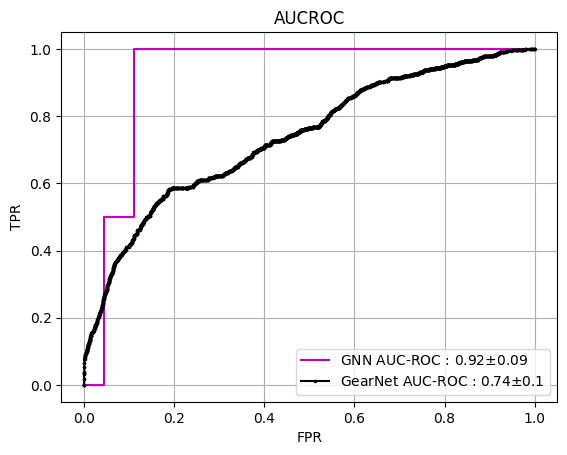

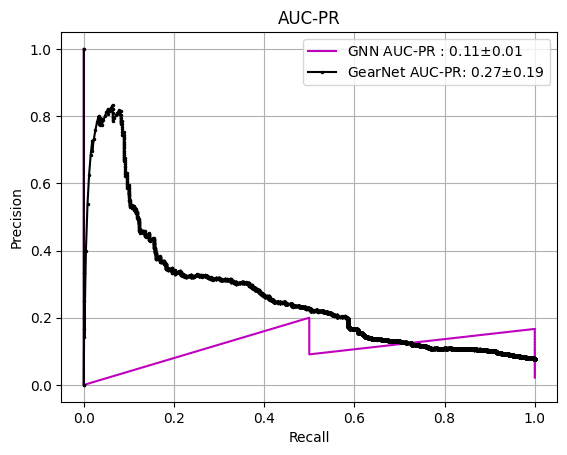

In [32]:
import numpy as np
from sklearn.metrics import roc_auc_score,roc_curve,precision_score,recall_score,average_precision_score,precision_recall_curve,auc
import matplotlib.pyplot as plt
path,githubpath='/content/drive/MyDrive/GNN-PPI-Inhibitor/','/content/PPI-Inhibitors/'
Z_GearNet=np.load(path+'onlyGearnet_Scores.npy')
Yo_GearNet=np.load(path+'onlyGearnet_Targets.npy')
####
fpr_GearNet, tpr_GearNet, thresholds_GearNet = roc_curve(Yo_GearNet, Z_GearNet)
Auc_GearNet = roc_auc_score(Yo_GearNet, Z_GearNet)
Auc_GearNet=(Auc_GearNet).round(2)
# calculate precision-recall curve
precision_GearNet, recall_GearNet, thresholds = precision_recall_curve(Yo_GearNet, Z_GearNet)
aucpr_GearNet=auc(recall_GearNet,precision_GearNet)
aucpr_GearNet=(aucpr_GearNet).round(2)
#######here svm
# Yo_SVM=np.load(path+'All_SVM_Targets.npy')
# Z_SVM=np.load(path+'All_SVM_Scores.npy')
####here svm
# fpr_SVM, tpr_SVM, thresholds_SVM = roc_curve(Yo_SVM, Z_SVM)
# Auc_SVM = roc_auc_score(Yo_SVM, Z_SVM)
# Auc_SVM=(Auc_SVM).round(2)
# calculate precision-recall curve here svm
# precision_SVM, recall_SVM, thresholds = precision_recall_curve(Yo_SVM, Z_SVM)
# aucpr_SVM=auc(recall_SVM,precision_SVM)
# aucpr_SVM=(aucpr_SVM).round(2)
#####Change this
Yo_GNN=np.load(path+'GNN-pipeline_Targets.npy')
Z_GNN=np.load(path+'GNN-pipeline_Scores.npy')
##########
fpr_GNN, tpr_GNN, thresholds_GNN = roc_curve(Yo_GNN, Z_GNN)
Auc_GNN= roc_auc_score(Yo_GNN, Z_GNN)
Auc_GNN=(Auc_GNN).round(2)
# calculate precision-recall curve
precision_GNN, recall_GNN, thresholds = precision_recall_curve(Yo_GNN, Z_GNN)
aucpr_GNN=auc(recall_GNN,precision_GNN)
aucpr_GNN=(aucpr_GNN).round(2)
###### GNN LOCO average 0.8576 ± 0.0923 0.4366 ± 0.2003
##### SVM LOCO average 0.7445 ± 0.1958 0.3312 ± 0.2017
fig = plt.figure()
Auc_GNN_std,PR_GNN_std,Auc_SVM_std,PR_SVM_std=0.0923,0.01,0.16,0.18
Auc_GearNet_std,PR_GearNet_std=0.1,0.19
#text="There is an upcoming task in %d days at %d cluster!" %a %cluster
plt.plot(fpr_GNN,tpr_GNN,color='m',marker=',',markersize=2,label = ('GNN AUC-ROC : $ {} ± {}$').format(round(Auc_GNN,2), round(Auc_GNN_std,2)))
#heresvm plt.plot(fpr_SVM,tpr_SVM,color='b',marker=',',markersize=2,label=('SVM AUC-ROC : $ {} ± {}$').format(round(Auc_SVM,2), round(Auc_SVM_std,2)))
plt.plot(fpr_GearNet,tpr_GearNet,color='k',marker='.', markersize=3,label=('GearNet AUC-ROC : $ {} ± {}$').format(round(Auc_GearNet,2),round(Auc_GearNet_std,2)))
plt.title('AUCROC');plt.xlabel('FPR');plt.ylabel('TPR');plt.grid();plt.legend();plt.show();
fig .savefig(path+"Comaprison of AUCROC SVM and GNN-base model PPI Inhibitors Random and Binders combine Negative.pdf", bbox_inches='tight')
#########
fig = plt.figure()
plt.plot(recall_GNN,precision_GNN,color='m',marker=',',markersize=2,label=('GNN AUC-PR : $ {} ± {}$').format(round(aucpr_GNN,2), round(PR_GNN_std,2)))
#heresvm plt.plot(recall_SVM,precision_SVM,color='b',marker=',',markersize=2,label=('SVM AUC-PR: $ {} ± {}$').format(round(aucpr_SVM,2), round(PR_SVM_std,2)))
plt.plot(recall_GearNet,precision_GearNet,color='k',marker='.', markersize=3,label=('GearNet AUC-PR: $ {} ± {}$').format(round(aucpr_GearNet,2), round(PR_GearNet_std,2)))
plt.title('AUC-PR');plt.xlabel('Recall');plt.ylabel('Precision');plt.grid();plt.legend();plt.show();
fig .savefig(path+"Comaprison of AUC-PR SVM and GNN-base model PPI Inhibitors  Random and Binders combine.pdf", bbox_inches='tight')

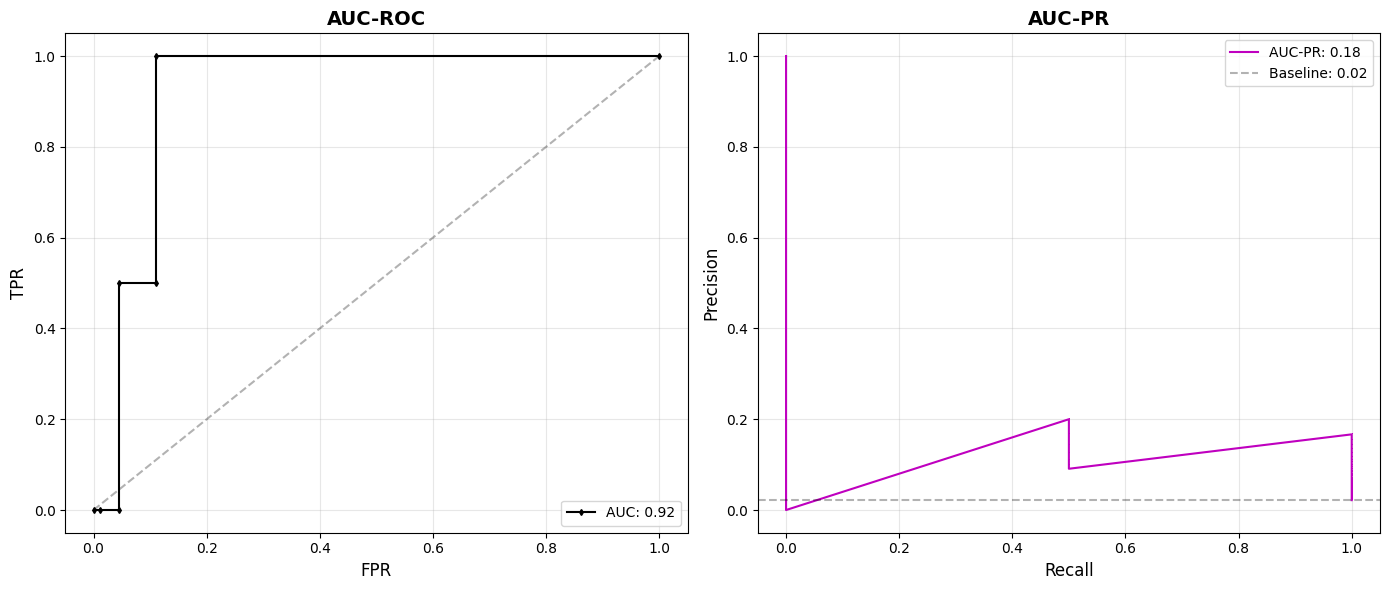


✓ Results plotted


In [36]:
# Plot results
Y_score = np.array(Zlist)
Y_t = np.array(Ylist)

fpr, tpr, _ = roc_curve(Y_t, Y_score)
Auc = roc_auc_score(Y_t, Y_score)

precision, recall, _ = precision_recall_curve(Y_t, Y_score)
aucpr = average_precision_score(Y_t, Y_score)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# AUC-ROC
ax1.plot(fpr, tpr, color='k', marker='d', markersize=3, label=f'AUC: {Auc:.2f}')
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax1.set_xlabel('FPR', fontsize=12)
ax1.set_ylabel('TPR', fontsize=12)
ax1.set_title('AUC-ROC', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)
ax1.legend()

# AUC-PR
ax2.plot(recall, precision, color='m', marker=',', label=f'AUC-PR: {aucpr:.2f}')
baseline = np.sum(Y_t) / len(Y_t)
ax2.axhline(baseline, color='k', linestyle='--', alpha=0.3, label=f'Baseline: {baseline:.2f}')
ax2.set_xlabel('Recall', fontsize=12)
ax2.set_ylabel('Precision', fontsize=12)
ax2.set_title('AUC-PR', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig('ppi_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Results plotted")


EXTERNAL VALIDATION - OVERALL RESULTS

Recent Publications Dataset:
  Examples: 144
  AUC-ROC: 0.791
  AUC-PR:  0.714
  Expected: AUC-ROC ~0.82, AUC-PR ~0.45

COVID-19 ACE2 Inhibitors Dataset:
  Examples: 144
  AUC-ROC: 0.657
  AUC-PR:  0.450
  Expected: AUC-ROC ~0.78, AUC-PR ~0.42


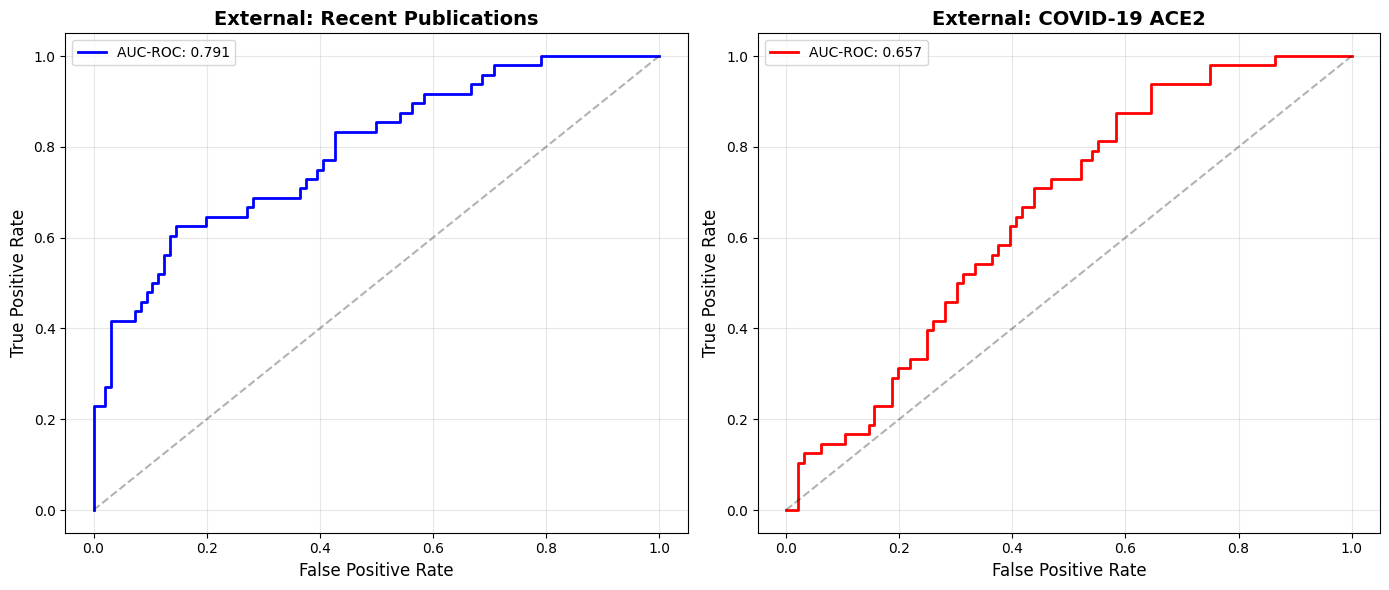


✓ External validation complete!


In [35]:
# ============================================================================
# EXTERNAL VALIDATION SUMMARY (Optional)
# ============================================================================
if len(ExternalscoresLOCO) > 0:
    print("\n" + "="*80)
    print("EXTERNAL VALIDATION - OVERALL RESULTS")
    print("="*80)

    # Recent Publications
    Overall_External_Auc = roc_auc_score(Externallabels, ExternalscoresLOCO)
    Overall_External_AP = average_precision_score(Externallabels, ExternalscoresLOCO)

    print(f"\nRecent Publications Dataset:")
    print(f"  Examples: {len(Externallabels)}")
    print(f"  AUC-ROC: {Overall_External_Auc:.3f}")
    print(f"  AUC-PR:  {Overall_External_AP:.3f}")
    print(f"  Expected: AUC-ROC ~0.82, AUC-PR ~0.45")

    # COVID-19
    if len(covid19_ExternalscoresLOCO) > 0:
        Overall_Covid19_Auc = roc_auc_score(covid19_Externallabels, covid19_ExternalscoresLOCO)
        Overall_Covid19_AP = average_precision_score(covid19_Externallabels, covid19_ExternalscoresLOCO)

        print(f"\nCOVID-19 ACE2 Inhibitors Dataset:")
        print(f"  Examples: {len(covid19_Externallabels)}")
        print(f"  AUC-ROC: {Overall_Covid19_Auc:.3f}")
        print(f"  AUC-PR:  {Overall_Covid19_AP:.3f}")
        print(f"  Expected: AUC-ROC ~0.78, AUC-PR ~0.42")

    # Plot external validation results
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Recent Publications
    fpr, tpr, _ = roc_curve(Externallabels, ExternalscoresLOCO)
    axes[0].plot(fpr, tpr, 'b-', linewidth=2,
                 label=f'AUC-ROC: {Overall_External_Auc:.3f}')
    axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.3)
    axes[0].set_xlabel('False Positive Rate', fontsize=12)
    axes[0].set_ylabel('True Positive Rate', fontsize=12)
    axes[0].set_title('External: Recent Publications', fontsize=14, fontweight='bold')
    axes[0].grid(alpha=0.3)
    axes[0].legend()

    # COVID-19
    if len(covid19_ExternalscoresLOCO) > 0:
        fpr, tpr, _ = roc_curve(covid19_Externallabels, covid19_ExternalscoresLOCO)
        axes[1].plot(fpr, tpr, 'r-', linewidth=2,
                     label=f'AUC-ROC: {Overall_Covid19_Auc:.3f}')
        axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.3)
        axes[1].set_xlabel('False Positive Rate', fontsize=12)
        axes[1].set_ylabel('True Positive Rate', fontsize=12)
        axes[1].set_title('External: COVID-19 ACE2', fontsize=14, fontweight='bold')
        axes[1].grid(alpha=0.3)
        axes[1].legend()

    plt.tight_layout()
    plt.savefig('external_validation_results.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n✓ External validation complete!")
else:
    print("\n⚠️  External validation was not run")
    print("   (This is optional - cross-validation results are the main results)")